In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random

from model import encoder, decoder
from data_loader import DataLoaderforReconstOpt, DataLoaderforLatentOpt, DataLoaderforVocoder
from utils import connect

from config import wave_len
from config import window_size
from config import data_dim
from config import latent_dim
from config import batch_size

(10370160, 2) 48000


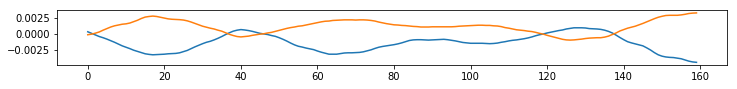

['../VoiceData/tamaneuta/trim_data/utama1.wav',
 '../VoiceData/tamaneuta/trim_data/utama2.wav',
 '../VoiceData/tamaneuta/trim_data/utama3.wav',
 '../VoiceData/tamaneuta/trim_data/utama4.wav',
 '../VoiceData/tamaneuta/trim_data/utama5.wav',
 '../VoiceData/tamaneuta/trim_data/utama6.wav',
 '../VoiceData/tamaneuta/trim_data/utama7.wav',
 '../VoiceData/tamaneuta/trim_data/utama8.wav',
 '../VoiceData/tamaneuta/trim_data/utama9.wav']

In [2]:
import soundfile as sf
import os

path = "../VoiceData/tamaneuta/trim_data/"
files = sorted(os.listdir(path))
files = [path + file for file in files]

data, rate = sf.read(files[0]) # rate == 48000 # samplerate:1秒あたりのフレーム数
print(data.shape, rate) # rateは最後のvocoder時に使う
plt.figure(figsize=(12,1))
plt.plot(data[10000:10000+wave_len])
plt.show()

files

In [3]:
# inputs = tf.placeholder(tf.float32, (None, wave_len, data_dim))

# with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
#     encoded = encoder(tf.reshape(inputs, (-1, wave_len, 1, data_dim)))

# with tf.variable_scope('decoder', reuse=tf.AUTO_REUSE):
#     decoded = tf.reshape(decoder(encoded), (-1, wave_len, data_dim))

# variables =  tf.trainable_variables()
# decoder_vars = [var for var in variables if 'decoder/' in var.name]

inputs = tf.placeholder(tf.float32, (None, wave_len, data_dim))

with tf.variable_scope('encoder', reuse=tf.AUTO_REUSE):
    encoded, z_mean, z_log_var = encoder(tf.reshape(inputs, (-1, wave_len, 1, data_dim)))

with tf.variable_scope('decoder', reuse=tf.AUTO_REUSE):
    decoded = tf.reshape(decoder(encoded), (-1, wave_len, data_dim))

rec_loss = tf.reduce_mean(tf.pow(inputs - decoded, 2))# + 
kl_loss = tf.reduce_mean(0.5 * tf.reduce_sum(tf.exp(z_log_var) + tf.square(z_mean) - 1 -z_log_var, 1))

variables =  tf.trainable_variables()
encoder_vars = [var for var in variables if 'encoder/' in var.name]
decoder_vars = [var for var in variables if 'decoder/' in var.name]

In [4]:
lr = 8e-4
beta1= 0.5
beta2 = 0.9

# rec_loss = tf.reduce_mean(tf.pow(inputs - decoded, 2))
# rec_opt = tf.train.AdamOptimizer(learning_rate=0.001).minimize(rec_loss)

# lat_weight = tf.placeholder(tf.float32, 1)
kl_weight = tf.placeholder(tf.float32, 1)

opt = tf.train.AdamOptimizer(learning_rate=0.001).minimize(rec_loss+kl_loss*kl_weight)# 0.01

【wave】
amp: 0.02667236328125


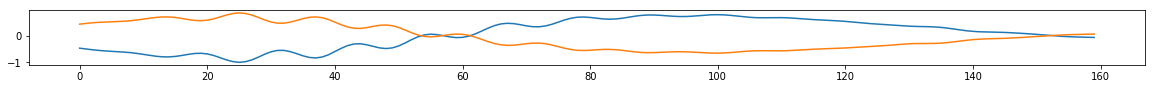

--------------------------------------------------------------------------------
amp: 0.060272216796875


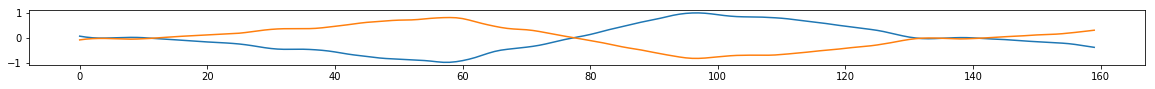

--------------------------------------------------------------------------------
amp: 0.032989501953125


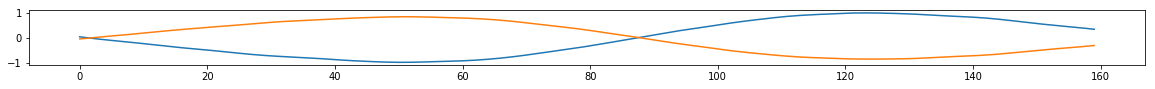

--------------------------------------------------------------------------------
amp: 0.06097412109375


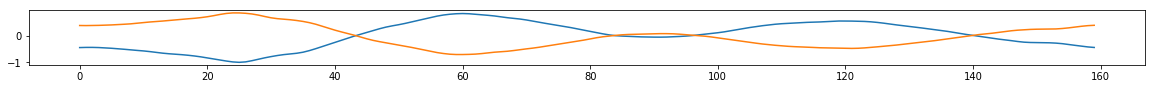

--------------------------------------------------------------------------------
【amp】 # max(amp)==0.231170654296875, mean(amp)==0.03477486534649207


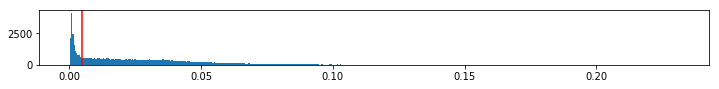

data.shape == (49683, 160, 2)
amp.shape == (49683,)


In [5]:
data_loader_rec = DataLoaderforReconstOpt(files)
_ = data_loader_rec.load(0, DEMO=True)

In [6]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

saver = tf.train.Saver() # tf.train.Saver(decoder_vars)
# saver.restore(sess, './model/model-3')

epoch = 0

In [7]:
max_epoch = 10

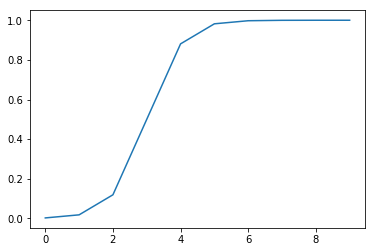

In [8]:
# w = [(np.tanh(step - 3) + 1) / 2 for step in range(10)]
# plt.plot(w); plt.show()

In [9]:
from tqdm import tqdm

data_loader_rec = DataLoaderforReconstOpt(files)

for _ in range(epoch, max_epoch):    
    for file in range(len(files)):
        
        data, _ = data_loader_rec.load(file)
        
        rec_loss_hist = []
        kl_loss_hist = []
        
        for index in tqdm(range(0,len(data), batch_size)):
            batch = data[index:index+batch_size]
            _kl_weight = [0.01]
#             _kl_weight = [(np.tanh(epoch - 3) + 1) / 2]
            
            _, _rec_loss, _kl_loss = sess.run([opt, rec_loss, kl_loss], {inputs: batch, kl_weight:_kl_weight})
            
            rec_loss_hist.append(_rec_loss)
            kl_loss_hist.append(_kl_loss)
            
        print("epoch:", epoch+1, "file:", file+1, 
              ", rec_loss:", np.mean(rec_loss_hist), 
              ", kl_loss:", np.mean(kl_loss_hist), 
              ", kl_weight:", _kl_weight)
    saver.save(sess, './model/model', global_step=epoch+1)
    epoch += 1

100%|██████████| 388/388 [00:18<00:00, 20.76it/s]


epoch: 1 file: 1 , rec_loss: 0.0763938 , kl_loss: 4.314619 , kl_weight: [0.01]


100%|██████████| 423/423 [00:18<00:00, 22.31it/s]


epoch: 1 file: 2 , rec_loss: 0.05079538 , kl_loss: 4.6599193 , kl_weight: [0.01]


100%|██████████| 410/410 [00:18<00:00, 22.15it/s]


epoch: 1 file: 3 , rec_loss: 0.050994534 , kl_loss: 4.646207 , kl_weight: [0.01]


100%|██████████| 397/397 [00:18<00:00, 21.72it/s]


epoch: 1 file: 4 , rec_loss: 0.05045056 , kl_loss: 4.6151376 , kl_weight: [0.01]


100%|██████████| 415/415 [00:18<00:00, 22.02it/s]


epoch: 1 file: 5 , rec_loss: 0.04702907 , kl_loss: 4.536367 , kl_weight: [0.01]


100%|██████████| 443/443 [00:19<00:00, 22.37it/s]


epoch: 1 file: 6 , rec_loss: 0.055583227 , kl_loss: 4.637599 , kl_weight: [0.01]


100%|██████████| 423/423 [00:19<00:00, 21.61it/s]


epoch: 1 file: 7 , rec_loss: 0.051310014 , kl_loss: 4.6964974 , kl_weight: [0.01]


100%|██████████| 397/397 [00:18<00:00, 21.48it/s]


epoch: 1 file: 8 , rec_loss: 0.048099324 , kl_loss: 4.6667256 , kl_weight: [0.01]


100%|██████████| 398/398 [00:18<00:00, 21.35it/s]


epoch: 1 file: 9 , rec_loss: 0.046929423 , kl_loss: 4.8227105 , kl_weight: [0.01]


100%|██████████| 389/389 [00:18<00:00, 21.03it/s]


epoch: 2 file: 1 , rec_loss: 0.04182382 , kl_loss: 4.7252045 , kl_weight: [0.01]


100%|██████████| 423/423 [00:19<00:00, 21.30it/s]


epoch: 2 file: 2 , rec_loss: 0.043904386 , kl_loss: 4.769779 , kl_weight: [0.01]


100%|██████████| 410/410 [00:19<00:00, 21.36it/s]


epoch: 2 file: 3 , rec_loss: 0.046092384 , kl_loss: 4.7860165 , kl_weight: [0.01]


100%|██████████| 398/398 [00:18<00:00, 21.21it/s]


epoch: 2 file: 4 , rec_loss: 0.045923855 , kl_loss: 4.782961 , kl_weight: [0.01]


100%|██████████| 415/415 [00:19<00:00, 20.87it/s]


epoch: 2 file: 5 , rec_loss: 0.043695092 , kl_loss: 4.68239 , kl_weight: [0.01]


100%|██████████| 443/443 [00:20<00:00, 21.21it/s]


epoch: 2 file: 6 , rec_loss: 0.052110523 , kl_loss: 4.7617574 , kl_weight: [0.01]


100%|██████████| 423/423 [00:20<00:00, 21.15it/s]


epoch: 2 file: 7 , rec_loss: 0.049521636 , kl_loss: 4.753951 , kl_weight: [0.01]


100%|██████████| 397/397 [00:18<00:00, 21.79it/s]


epoch: 2 file: 8 , rec_loss: 0.046647795 , kl_loss: 4.7012506 , kl_weight: [0.01]


100%|██████████| 397/397 [00:18<00:00, 21.66it/s]


epoch: 2 file: 9 , rec_loss: 0.045649648 , kl_loss: 4.8420424 , kl_weight: [0.01]


100%|██████████| 388/388 [00:18<00:00, 20.92it/s]


epoch: 3 file: 1 , rec_loss: 0.04109696 , kl_loss: 4.710599 , kl_weight: [0.01]


100%|██████████| 423/423 [00:19<00:00, 21.17it/s]


epoch: 3 file: 2 , rec_loss: 0.04300163 , kl_loss: 4.7717276 , kl_weight: [0.01]


100%|██████████| 409/409 [00:19<00:00, 20.95it/s]


epoch: 3 file: 3 , rec_loss: 0.044918768 , kl_loss: 4.8015523 , kl_weight: [0.01]


100%|██████████| 397/397 [00:18<00:00, 21.07it/s]


epoch: 3 file: 4 , rec_loss: 0.044832505 , kl_loss: 4.778131 , kl_weight: [0.01]


100%|██████████| 415/415 [00:19<00:00, 20.97it/s]


epoch: 3 file: 5 , rec_loss: 0.043080147 , kl_loss: 4.6853814 , kl_weight: [0.01]


100%|██████████| 443/443 [00:20<00:00, 21.21it/s]


epoch: 3 file: 6 , rec_loss: 0.051363815 , kl_loss: 4.7780175 , kl_weight: [0.01]


100%|██████████| 423/423 [00:19<00:00, 21.77it/s]


epoch: 3 file: 7 , rec_loss: 0.049000133 , kl_loss: 4.7450757 , kl_weight: [0.01]


100%|██████████| 397/397 [00:18<00:00, 21.13it/s]


epoch: 3 file: 8 , rec_loss: 0.046153966 , kl_loss: 4.7028465 , kl_weight: [0.01]


100%|██████████| 398/398 [00:18<00:00, 21.70it/s]


epoch: 3 file: 9 , rec_loss: 0.044963952 , kl_loss: 4.8416595 , kl_weight: [0.01]


100%|██████████| 389/389 [00:18<00:00, 21.47it/s]


epoch: 4 file: 1 , rec_loss: 0.040445156 , kl_loss: 4.735221 , kl_weight: [0.01]


100%|██████████| 423/423 [00:19<00:00, 21.74it/s]


epoch: 4 file: 2 , rec_loss: 0.042518783 , kl_loss: 4.7841167 , kl_weight: [0.01]


100%|██████████| 409/409 [00:19<00:00, 21.09it/s]


epoch: 4 file: 3 , rec_loss: 0.044504747 , kl_loss: 4.80554 , kl_weight: [0.01]


100%|██████████| 397/397 [00:18<00:00, 21.80it/s]


epoch: 4 file: 4 , rec_loss: 0.044252843 , kl_loss: 4.7961164 , kl_weight: [0.01]


100%|██████████| 415/415 [00:19<00:00, 21.75it/s]


epoch: 4 file: 5 , rec_loss: 0.042585157 , kl_loss: 4.693331 , kl_weight: [0.01]


100%|██████████| 443/443 [00:20<00:00, 21.35it/s]


epoch: 4 file: 6 , rec_loss: 0.050914515 , kl_loss: 4.7926865 , kl_weight: [0.01]


100%|██████████| 423/423 [00:19<00:00, 21.54it/s]


epoch: 4 file: 7 , rec_loss: 0.048637055 , kl_loss: 4.7658453 , kl_weight: [0.01]


100%|██████████| 397/397 [00:18<00:00, 21.24it/s]


epoch: 4 file: 8 , rec_loss: 0.045923278 , kl_loss: 4.7154036 , kl_weight: [0.01]


100%|██████████| 398/398 [00:18<00:00, 21.30it/s]


epoch: 4 file: 9 , rec_loss: 0.044760335 , kl_loss: 4.8437486 , kl_weight: [0.01]


100%|██████████| 389/389 [00:18<00:00, 21.22it/s]


epoch: 5 file: 1 , rec_loss: 0.040047992 , kl_loss: 4.737054 , kl_weight: [0.01]


100%|██████████| 423/423 [00:19<00:00, 21.35it/s]


epoch: 5 file: 2 , rec_loss: 0.042109814 , kl_loss: 4.7941914 , kl_weight: [0.01]


100%|██████████| 409/409 [00:19<00:00, 21.16it/s]


epoch: 5 file: 3 , rec_loss: 0.04414538 , kl_loss: 4.8094077 , kl_weight: [0.01]


100%|██████████| 397/397 [00:18<00:00, 21.14it/s]


epoch: 5 file: 4 , rec_loss: 0.043861717 , kl_loss: 4.82075 , kl_weight: [0.01]


100%|██████████| 415/415 [00:20<00:00, 20.74it/s]


epoch: 5 file: 5 , rec_loss: 0.042297896 , kl_loss: 4.690496 , kl_weight: [0.01]


100%|██████████| 443/443 [00:20<00:00, 21.43it/s]


epoch: 5 file: 6 , rec_loss: 0.05061548 , kl_loss: 4.7838936 , kl_weight: [0.01]


100%|██████████| 423/423 [00:19<00:00, 21.91it/s]


epoch: 5 file: 7 , rec_loss: 0.048421144 , kl_loss: 4.7684207 , kl_weight: [0.01]


100%|██████████| 397/397 [00:18<00:00, 21.25it/s]


epoch: 5 file: 8 , rec_loss: 0.045852084 , kl_loss: 4.7049575 , kl_weight: [0.01]


100%|██████████| 397/397 [00:18<00:00, 20.98it/s]


epoch: 5 file: 9 , rec_loss: 0.04447132 , kl_loss: 4.862956 , kl_weight: [0.01]


100%|██████████| 389/389 [00:18<00:00, 21.03it/s]


epoch: 6 file: 1 , rec_loss: 0.039884266 , kl_loss: 4.7265024 , kl_weight: [0.01]


100%|██████████| 423/423 [00:20<00:00, 20.87it/s]


epoch: 6 file: 2 , rec_loss: 0.04202449 , kl_loss: 4.7686386 , kl_weight: [0.01]


100%|██████████| 410/410 [00:19<00:00, 21.28it/s]


epoch: 6 file: 3 , rec_loss: 0.044005603 , kl_loss: 4.8222203 , kl_weight: [0.01]


100%|██████████| 397/397 [00:18<00:00, 21.79it/s]


epoch: 6 file: 4 , rec_loss: 0.043746594 , kl_loss: 4.804617 , kl_weight: [0.01]


100%|██████████| 415/415 [00:19<00:00, 20.89it/s]


epoch: 6 file: 5 , rec_loss: 0.042102642 , kl_loss: 4.694208 , kl_weight: [0.01]


100%|██████████| 443/443 [00:20<00:00, 21.87it/s]


epoch: 6 file: 6 , rec_loss: 0.05053533 , kl_loss: 4.800207 , kl_weight: [0.01]


100%|██████████| 423/423 [00:20<00:00, 21.15it/s]


epoch: 6 file: 7 , rec_loss: 0.048198223 , kl_loss: 4.7722726 , kl_weight: [0.01]


100%|██████████| 397/397 [00:18<00:00, 21.22it/s]


epoch: 6 file: 8 , rec_loss: 0.04552514 , kl_loss: 4.706927 , kl_weight: [0.01]


100%|██████████| 397/397 [00:18<00:00, 21.05it/s]


epoch: 6 file: 9 , rec_loss: 0.044206135 , kl_loss: 4.869413 , kl_weight: [0.01]


100%|██████████| 389/389 [00:18<00:00, 20.72it/s]


epoch: 7 file: 1 , rec_loss: 0.03957044 , kl_loss: 4.747441 , kl_weight: [0.01]


100%|██████████| 423/423 [00:19<00:00, 21.34it/s]


epoch: 7 file: 2 , rec_loss: 0.041708287 , kl_loss: 4.7986054 , kl_weight: [0.01]


100%|██████████| 409/409 [00:19<00:00, 21.02it/s]


epoch: 7 file: 3 , rec_loss: 0.043745045 , kl_loss: 4.8156266 , kl_weight: [0.01]


100%|██████████| 397/397 [00:18<00:00, 21.73it/s]


epoch: 7 file: 4 , rec_loss: 0.043372612 , kl_loss: 4.8143945 , kl_weight: [0.01]


100%|██████████| 415/415 [00:19<00:00, 21.10it/s]


epoch: 7 file: 5 , rec_loss: 0.041969124 , kl_loss: 4.69804 , kl_weight: [0.01]


100%|██████████| 443/443 [00:20<00:00, 21.80it/s]


epoch: 7 file: 6 , rec_loss: 0.05028205 , kl_loss: 4.8004794 , kl_weight: [0.01]


100%|██████████| 423/423 [00:19<00:00, 21.17it/s]


epoch: 7 file: 7 , rec_loss: 0.048189394 , kl_loss: 4.7708087 , kl_weight: [0.01]


100%|██████████| 397/397 [00:18<00:00, 21.88it/s]


epoch: 7 file: 8 , rec_loss: 0.04546829 , kl_loss: 4.711401 , kl_weight: [0.01]


100%|██████████| 397/397 [00:18<00:00, 21.03it/s]


epoch: 7 file: 9 , rec_loss: 0.04400169 , kl_loss: 4.8656583 , kl_weight: [0.01]


100%|██████████| 389/389 [00:17<00:00, 22.02it/s]


epoch: 8 file: 1 , rec_loss: 0.039460056 , kl_loss: 4.748209 , kl_weight: [0.01]


100%|██████████| 424/424 [00:19<00:00, 21.84it/s]


epoch: 8 file: 2 , rec_loss: 0.04176219 , kl_loss: 4.778083 , kl_weight: [0.01]


100%|██████████| 409/409 [00:18<00:00, 21.87it/s]


epoch: 8 file: 3 , rec_loss: 0.043715317 , kl_loss: 4.819141 , kl_weight: [0.01]


100%|██████████| 397/397 [00:18<00:00, 21.11it/s]


epoch: 8 file: 4 , rec_loss: 0.043316048 , kl_loss: 4.8097105 , kl_weight: [0.01]


100%|██████████| 415/415 [00:19<00:00, 21.67it/s]


epoch: 8 file: 5 , rec_loss: 0.04193221 , kl_loss: 4.693351 , kl_weight: [0.01]


100%|██████████| 443/443 [00:20<00:00, 21.24it/s]


epoch: 8 file: 6 , rec_loss: 0.05027622 , kl_loss: 4.796428 , kl_weight: [0.01]


100%|██████████| 423/423 [00:19<00:00, 21.73it/s]


epoch: 8 file: 7 , rec_loss: 0.048018526 , kl_loss: 4.774136 , kl_weight: [0.01]


100%|██████████| 397/397 [00:18<00:00, 21.90it/s]


epoch: 8 file: 8 , rec_loss: 0.045350816 , kl_loss: 4.7222958 , kl_weight: [0.01]


100%|██████████| 398/398 [00:18<00:00, 21.28it/s]


epoch: 8 file: 9 , rec_loss: 0.043805905 , kl_loss: 4.870905 , kl_weight: [0.01]


100%|██████████| 389/389 [00:17<00:00, 21.80it/s]


epoch: 9 file: 1 , rec_loss: 0.039287236 , kl_loss: 4.7617745 , kl_weight: [0.01]


100%|██████████| 423/423 [00:19<00:00, 21.77it/s]


epoch: 9 file: 2 , rec_loss: 0.04140335 , kl_loss: 4.8062887 , kl_weight: [0.01]


100%|██████████| 409/409 [00:19<00:00, 21.28it/s]


epoch: 9 file: 3 , rec_loss: 0.043620102 , kl_loss: 4.8256187 , kl_weight: [0.01]


100%|██████████| 398/398 [00:18<00:00, 21.39it/s]


epoch: 9 file: 4 , rec_loss: 0.04316328 , kl_loss: 4.819546 , kl_weight: [0.01]


100%|██████████| 415/415 [00:19<00:00, 21.15it/s]


epoch: 9 file: 5 , rec_loss: 0.041691814 , kl_loss: 4.7124996 , kl_weight: [0.01]


100%|██████████| 443/443 [00:20<00:00, 21.82it/s]


epoch: 9 file: 6 , rec_loss: 0.0500307 , kl_loss: 4.8109255 , kl_weight: [0.01]


100%|██████████| 423/423 [00:19<00:00, 21.19it/s]


epoch: 9 file: 7 , rec_loss: 0.047852 , kl_loss: 4.7693496 , kl_weight: [0.01]


100%|██████████| 397/397 [00:18<00:00, 21.21it/s]


epoch: 9 file: 8 , rec_loss: 0.04520374 , kl_loss: 4.710507 , kl_weight: [0.01]


100%|██████████| 397/397 [00:18<00:00, 21.88it/s]


epoch: 9 file: 9 , rec_loss: 0.043706 , kl_loss: 4.8690968 , kl_weight: [0.01]


100%|██████████| 389/389 [00:17<00:00, 21.96it/s]


epoch: 10 file: 1 , rec_loss: 0.039253347 , kl_loss: 4.7363515 , kl_weight: [0.01]


100%|██████████| 423/423 [00:19<00:00, 21.36it/s]


epoch: 10 file: 2 , rec_loss: 0.041389313 , kl_loss: 4.806709 , kl_weight: [0.01]


100%|██████████| 409/409 [00:18<00:00, 21.90it/s]


epoch: 10 file: 3 , rec_loss: 0.043452732 , kl_loss: 4.811107 , kl_weight: [0.01]


100%|██████████| 397/397 [00:19<00:00, 20.65it/s]


epoch: 10 file: 4 , rec_loss: 0.04309453 , kl_loss: 4.818165 , kl_weight: [0.01]


100%|██████████| 415/415 [00:18<00:00, 21.91it/s]


epoch: 10 file: 5 , rec_loss: 0.04150023 , kl_loss: 4.7205296 , kl_weight: [0.01]


100%|██████████| 443/443 [00:20<00:00, 21.18it/s]


epoch: 10 file: 6 , rec_loss: 0.049884297 , kl_loss: 4.8215823 , kl_weight: [0.01]


100%|██████████| 423/423 [00:19<00:00, 21.87it/s]


epoch: 10 file: 7 , rec_loss: 0.0476879 , kl_loss: 4.7899413 , kl_weight: [0.01]


100%|██████████| 397/397 [00:18<00:00, 20.92it/s]


epoch: 10 file: 8 , rec_loss: 0.045129858 , kl_loss: 4.721762 , kl_weight: [0.01]


100%|██████████| 398/398 [00:18<00:00, 21.46it/s]

epoch: 10 file: 9 , rec_loss: 0.043642294 , kl_loss: 4.861756 , kl_weight: [0.01]


In [11]:
saver.save(sess, './model/model', global_step=epoch)

'./model/model-10'

inputs -> decoded
amp: 0.024383544921875


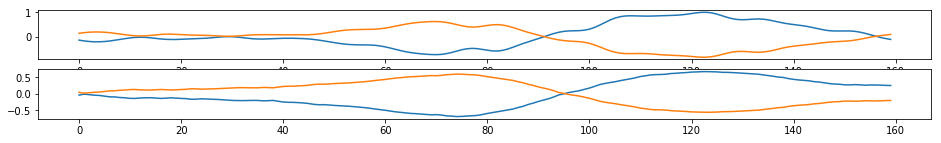

amp: 0.00543212890625


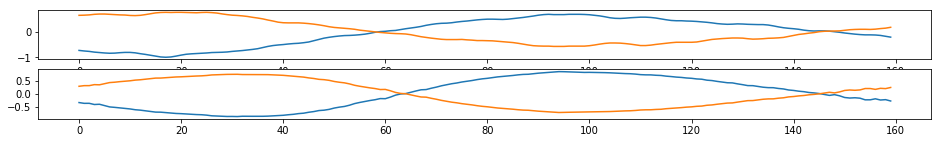

amp: 0.0621337890625


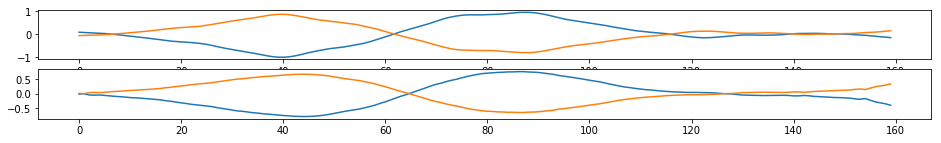

amp: 0.034912109375


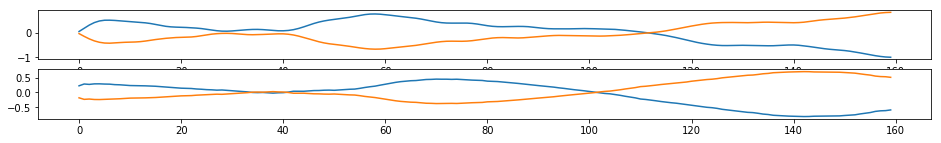

In [12]:
data_loader_rec = DataLoaderforReconstOpt(files)
data, amp = data_loader_rec.load(0)

print("inputs -> decoded")

for i in range(4):

    index = np.random.choice(len(data))
    x = data[index]
    a = amp[index]
    print("amp:", a)

    _x = x.reshape(wave_len, data_dim)
    plt.figure(figsize=(16,2));
    plt.subplot(2,1,1); plt.plot(_x);

    x = sess.run(decoded, {inputs: [_x]})
    plt.subplot(2,1,2); plt.plot(x[0]); plt.show()

### AutoEncode

In [14]:
from tqdm import tqdm

data_loader_voc = DataLoaderforVocoder(files)

ae_data = []

print("autoencoding...")

for fi in range(1):
    batch_size = 128
    data, amp = data_loader_voc.load(fi)

    for index in tqdm(range(0, len(data), batch_size)):
        batch_data = data[index:index+batch_size]
        batch_amp = amp[index:index+batch_size]
        _ae_data = sess.run(decoded, {inputs: batch_data})
        if not _ae_data.shape == (batch_size, 160,2):
            continue
        ae_data.extend(_ae_data*batch_amp.reshape(-1,1,1))       

ae_data = np.array(ae_data)
print("ae_data.shape ==", ae_data.shape)

print("connecting...")

concat_data = [ae_data[0, 60:-20]]

for _ae_data in tqdm(ae_data[1:]):
    _ae_data = _ae_data[20:-20] # 新しいデータ。最初と最後は切り捨てておく。(1560, 2)
    a = concat_data[-1][-40:] # 古いデータの尻。(40, 2)
    b = _ae_data[:40] # 新しいデータの頭。(40, 2)
    concat_data[-1][-40:,0] = connect(a[:,0],b[:,0]) # 古いデータを上書き
    concat_data[-1][-40:,1] = connect(a[:,1],b[:,1]) # 古いデータを上書き
    
    concat_data.append(_ae_data[40:])

print("writing...")

concat_data = np.array(concat_data).reshape(-1, data_dim)
sf.write("sample/3_vae-short-10ep.wav", concat_data, rate)

print("done")

autoencoding...


  2%|▏         | 1983/129535 [00:00<00:12, 9913.21it/s] 

ae_data.shape == (129536, 160, 2)
connecting...


100%|██████████| 129535/129535 [00:12<00:00, 10560.47it/s]


writing...
done


### Encoder
- 潜在空間への写像の様子をプロット

100%|██████████| 389/389 [00:03<00:00, 126.30it/s]


(49664, 64)


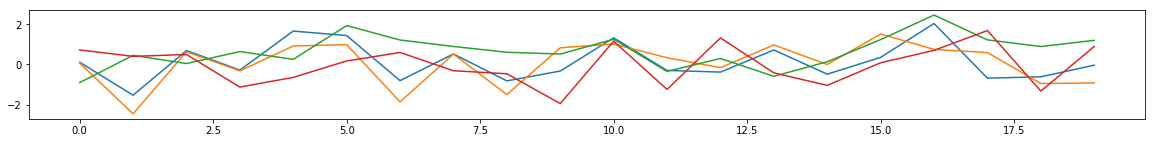

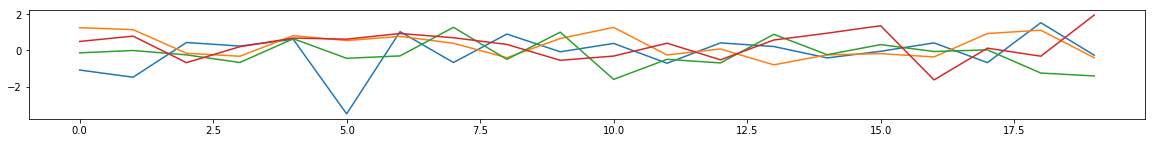

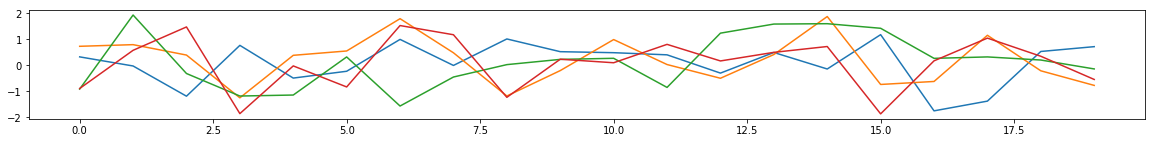

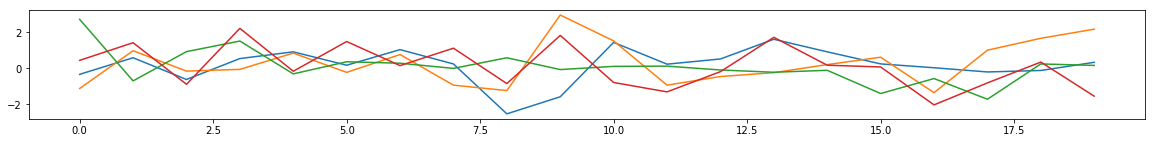

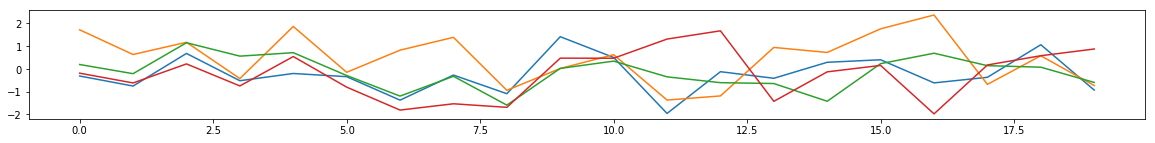

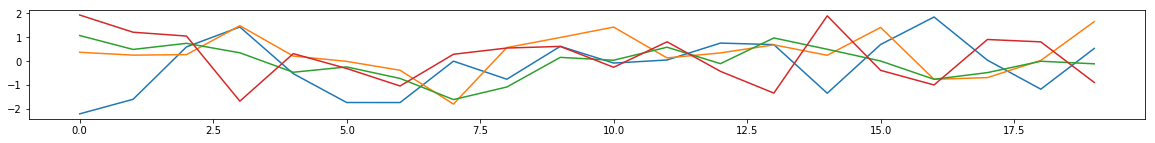

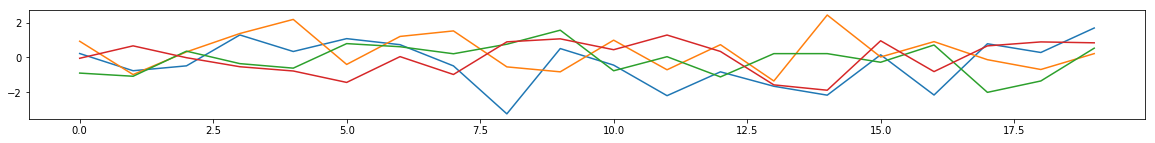

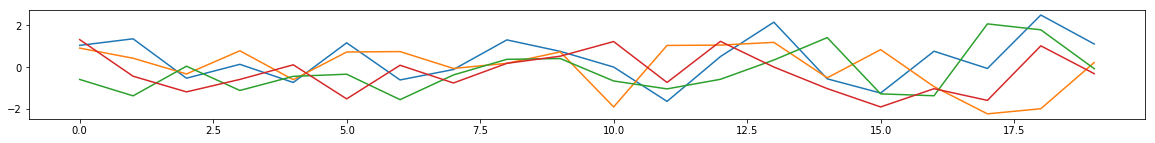

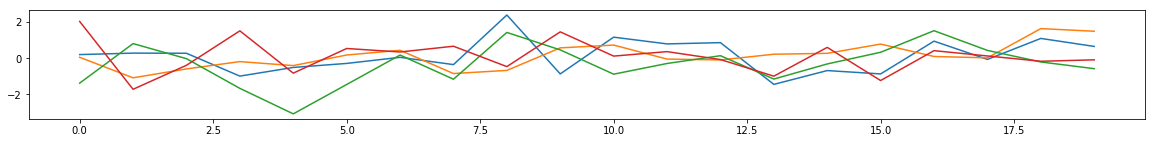

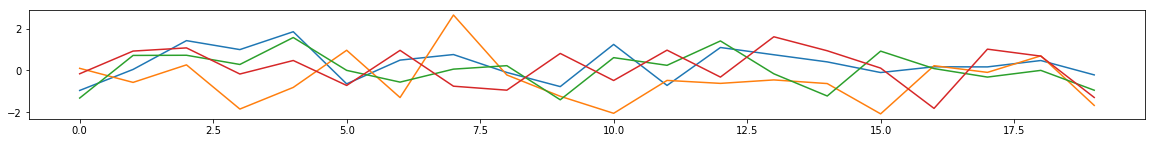

In [15]:
data_loader_rec = DataLoaderforReconstOpt(files)

ae_data = []

for fi in range(1):
    batch_size = 128
    data, amp = data_loader_rec.load(fi)

    for index in tqdm(range(0, len(data), batch_size)):
        batch_data = data[index:index+batch_size]
        batch_amp = amp[index:index+batch_size]
#         print(batch_data.shape) # (128, 160, 2)
        _ae_data = sess.run(encoded, {inputs: batch_data})
        if not _ae_data.shape == (batch_size, latent_dim):
            continue
        ae_data.extend(_ae_data)

ae_data = np.array(ae_data)
print(ae_data.shape)

for i in range(10):
    plt.figure(figsize=(20,2))
    _s = np.random.randint(len(ae_data)-10)
    _e = _s+20
    plt.plot(ae_data[_s:_e,i:i+4])
    plt.show()